In [33]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor,Compose,RandomHorizontalFlip, Normalize, ToPILImage, RandomRotation, ColorJitter
from torchvision.utils import make_grid
import mcbe


In [34]:
def relu_inv(output, W, b):
    """
    reconstructs x from z = ReLU(Wx - b) using a facet-specific left-inverse 
    setting mode to something else will use the whole active sub-frame
    """
    I = np.where(output > 0)[0] # active frame elements
    W_f = W[I,:]
    b_f = b[I]
    output_f = output[I]
    x = np.linalg.lstsq(W_f,  output_f + b_f, rcond=None)[0] # equivalent to synthesis with the canonical dual frame
    return x

In [35]:
model_cifar = torch.load('models_reconstruction/Final_Model_inj1_trained_further.pt')

In [63]:
model_cifar

OrderedDict([('conv1.weight',
              tensor([[[[-0.0761,  0.2286,  0.3690],
                        [-0.2710,  0.0370,  0.0685],
                        [-0.0194, -0.1945,  0.0226]],
              
                       [[ 0.0448, -0.1993, -0.1300],
                        [-0.2621, -0.0862, -0.0510],
                        [-0.1021,  0.1151,  0.1178]],
              
                       [[-0.0488, -0.1215, -0.1145],
                        [ 0.1663,  0.0688, -0.2188],
                        [ 0.0538,  0.2124,  0.1188]]],
              
              
                      [[[ 0.2076, -0.0096, -0.0753],
                        [-0.0256,  0.1645, -0.3260],
                        [-0.0851, -0.2404,  0.0149]],
              
                       [[-0.1438,  0.0698, -0.0496],
                        [-0.0784,  0.2309, -0.0908],
                        [-0.1240, -0.1979,  0.1282]],
              
                       [[ 0.0920,  0.1636,  0.1456],
                        [-

In [46]:
weights = model_cifar["fc2.weight"]
bias = model_cifar["fc2.bias"]

In [47]:
def extract(filename):
    with open(filename,"rb") as f:
        batch_data = pickle.load(f,encoding="bytes")
    return batch_data

data = [] #Store all batches in a list
for files in os.listdir("cifar-10-batches-py"):
    if "_batch" in files:
        data.append(extract(os.path.join('./cifar-10-batches-py',files)))

class CIFAR10(Dataset):
    
    def __init__(self,root,train=True,transforms=None):
        self.root = root
        self.transforms = transforms
        self.split = train
        
        self.data = []
        self.targets = []
        self.train_data = [file for file in os.listdir(root) if "data_batch" in file]
        self.test_data = [file for file in os.listdir(root) if "test_batch" in file]
                
        data_split = self.train_data if self.split else self.test_data
        
        for files in data_split:
            entry = self.extract(os.path.join(root,files))
            self.data.append(entry["data"])
            self.targets.extend(entry["labels"])
                
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))
        self.load_meta()
        
    def extract(self,filename):
        with open(filename,"rb") as f:
            batch_data = pickle.load(f,encoding="latin1")
        return batch_data  
    
    def load_meta(self):
        path = os.path.join(self.root,"batches.meta")
        with open(path,"rb") as infile:
            data = pickle.load(infile,encoding="latin1")
            self.classes = data["label_names"]
            self.classes_to_idx = {_class:i for i,_class in enumerate(self.classes)}
            
    def plot(self,image,target=None):
        if target is not None:
            print(f"Target :{target} class :{self.classes[target]}")
        plt.figure(figsize=(2,2))
        plt.imshow(image.permute(1,2,0))
        plt.show()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        image,target = self.data[idx],self.targets[idx]
        image = Image.fromarray(image)
        
        if self.transforms:
            image = self.transforms(image)
            
        return image,target
    
train_set = CIFAR10(root="./cifar-10-batches-py",train=True,
                    transforms=Compose([
                        ToTensor()]))
test_set = CIFAR10(root="./cifar-10-batches-py",train=False,
                    transforms=Compose([
                        ToTensor()]))

In [48]:
test_set = CIFAR10(root="./cifar-10-batches-py",train=False,
                    transforms=Compose([
                            ToTensor(),
                            Normalize(mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                    std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628))
                        ]))

In [49]:
class ConvNet_return_mcbe(nn.Module):

    def __init__(self):
        super(ConvNet_return_mcbe,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,stride=1,kernel_size=(3,3),padding=1)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=32,kernel_size=(3,3),padding=1,stride=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),padding=1,stride=1)
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),padding=1,stride=1)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1)

        self.fc1 = nn.Linear(in_features=6*6*256,out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=512)
        self.fc3 = nn.Linear(in_features=512,out_features=128)
        self.fc4 = nn.Linear(in_features=128,out_features=64)
        self.fc5 = nn.Linear(in_features=64,out_features=10)
        
        self.max_pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.dropout = nn.Dropout2d(p=0.5)
        
    def return_mcbe_input(self,x,targets,inj=True):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = x.view(-1,6*6*256)
        x = F.relu(self.fc1(x))
        mcbe_train = x.detach().numpy()
        return mcbe_train
    
    def return_mcbe_output(self,x,targets,inj=True):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = x.view(-1,6*6*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x.detach().numpy()

In [50]:
return_mcbe = ConvNet_return_mcbe()

In [70]:
weights.shape

torch.Size([512, 256])

In [73]:
return_mcbe.load_state_dict(torch.load("models_reconstruction/Final_Model_inj2.pt"))

<All keys matched successfully>

In [74]:
#get weights
weights = return_mcbe.fc2.weight.data

In [75]:
input = return_mcbe.return_mcbe_input(test_set.__getitem__(2)[0],test_set.__getitem__(2)[1])
output = return_mcbe.return_mcbe_output(test_set.__getitem__(2)[0],test_set.__getitem__(2)[1])

In [76]:
reconstructed_output = relu_inv(np.array(output)[0], np.array(weights), np.array(bias))

In [77]:
np.linalg.norm(reconstructed_output - np.array(input)[0])

53.0376

In [78]:
errors = []
for i in range(100):
    input = return_mcbe.return_mcbe_input(test_set.__getitem__(i)[0],test_set.__getitem__(i)[1])
    output = return_mcbe.return_mcbe_output(test_set.__getitem__(i)[0],test_set.__getitem__(i)[1])
    reconstructed_output = relu_inv(np.array(output)[0], np.array(weights), np.array(bias))
    errors.append(np.linalg.norm(reconstructed_output - np.array(input)[0]))

In [79]:
np.array([return_mcbe.return_mcbe_input(test_set.__getitem__(i)[0],test_set.__getitem__(i)[1]) for i in range(100)])

array([[[ 0.       ,  0.       , 10.266613 , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       ...,

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          3.5719955,  0.       ]],

       [[ 0.       ,  0.       ,  3.8008249, ...,  0.       ,
          0.       ,  0.       ]]], dtype=float32)

In [80]:
percent_inj = []
for i in range(100):
    percent_inj.append(mcbe.check_injectivity_naive(np.array(weights), np.array(bias), iter =1, points=np.array(return_mcbe.return_mcbe_input(train_set.__getitem__(i)[0],train_set.__getitem__(i)[1]))))


In [81]:
np.mean(percent_inj)

0.0

(array([  2., 248., 192.,  31.,  19.,   8.,   9.,   1.,   1.,   1.]),
 array([-0.13041063, -0.06640249, -0.00239437,  0.06161376,  0.1256219 ,
         0.18963003,  0.25363815,  0.31764629,  0.38165441,  0.44566256,
         0.50967067]),
 <BarContainer object of 10 artists>)

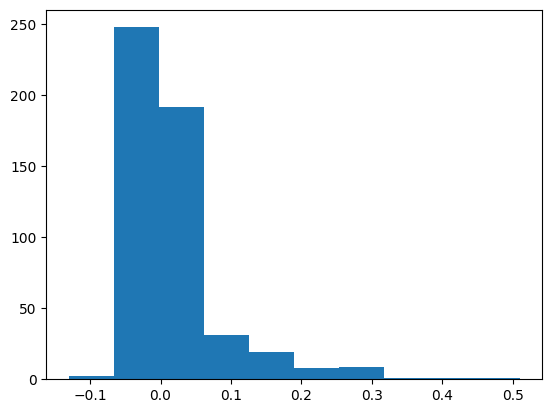

In [128]:
plt.hist(np.array(bias))

(array([  1.,   0.,   2.,  14.,  23.,  36.,  51.,  58.,  41., 286.]),
 array([-58.42527092, -52.57538365, -46.72549638, -40.8756091 ,
        -35.02572183, -29.17583456, -23.32594728, -17.47606001,
        -11.62617274,  -5.77628546,   0.07360181]),
 <BarContainer object of 10 artists>)

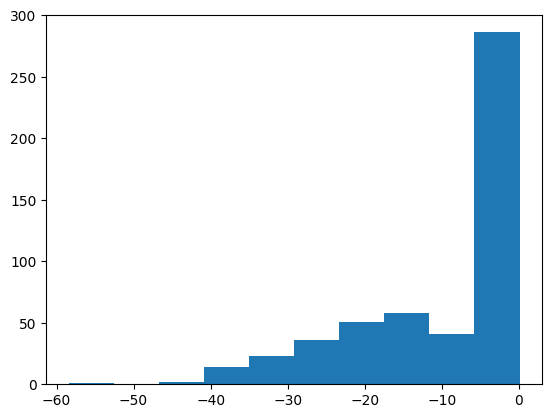

In [129]:
plt.hist(np.array(max_bias))

(array([287.,  40.,  58.,  52.,  35.,  23.,  14.,   2.,   0.,   1.]),
 array([-0.07607308,  5.77402984, 11.62413275, 17.47423566, 23.32433858,
        29.17444149, 35.0245444 , 40.87464732, 46.72475023, 52.57485314,
        58.42495606]),
 <BarContainer object of 10 artists>)

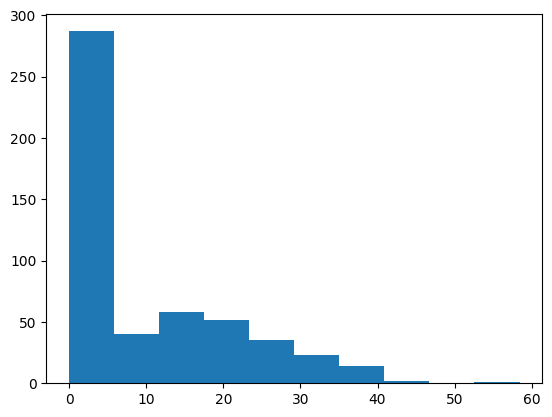

In [127]:
plt.hist(np.array(bias) - np.array(max_bias))

In [177]:
np.array([np.array(return_mcbe.return_mcbe_input(train_set.__getitem__(i)[0],train_set.__getitem__(i)[1])).flatten() for i in range(100)])

c:\Users\heckert\AppData\Local\anaconda3_new\envs\pbe\Lib\site-packages\torch\nn\functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


array([[ 0.      ,  0.      , 16.93454 , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 11.039252, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 10.419275, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [114]:
X_train = np.array([np.array(return_mcbe.return_mcbe_input(train_set.__getitem__(i)[0],train_set.__getitem__(i)[1])).flatten() for i in range(10000)])
X_test = np.array([np.array(return_mcbe.return_mcbe_input(test_set.__getitem__(i)[0],test_set.__getitem__(i)[1])).flatten() for i in range(100)])
weights = model_cifar["fc2.weight"]
weights = np.array(weights)

c:\Users\heckert\AppData\Local\anaconda3_new\envs\pbe\Lib\site-packages\torch\nn\functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [115]:
X_train.shape

(10000, 256)

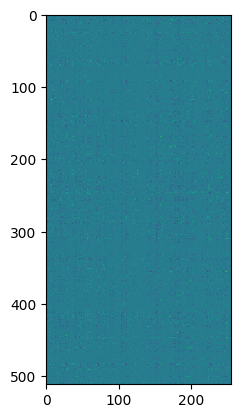

In [116]:
plt.imshow(weights)

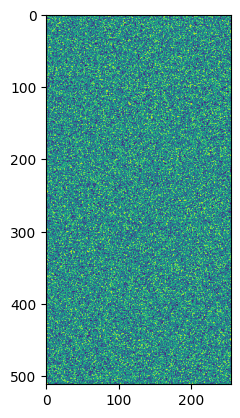

In [117]:
plt.imshow(np.random.random((512,256)))

In [118]:
#X_train = np.random.random((100,256))
#weights = np.random.random((512,256))

In [119]:
max_bias = mcbe.dd_mcbe(W=weights,X_train = X_train, num_estimation_points=10000,dd_method="blowup")

In [120]:
max_bias

array([-2.33307381e+01, -3.57731975e+01, -5.83705101e+00, -1.32027960e+01,
       -5.84252709e+01, -3.96423242e+00, -2.89837881e+01, -3.74630301e+00,
       -3.04705926e+00,  6.79888036e-02, -3.56712659e+00,  5.65365306e-02,
       -3.11636052e+00, -1.23953077e+00, -3.59077952e+01, -1.52238385e+01,
       -1.42287994e+01, -2.94365380e+01, -1.55082673e+01, -2.07938075e+01,
       -2.71814172e+01, -3.50079151e+00, -1.98987932e+00, -1.43878251e+01,
        6.10288746e-02, -2.66134444e+00,  3.81147728e-02, -1.81014210e+01,
       -3.74683777e+00, -3.88227792e+00,  4.15224445e-02,  5.53554216e-02,
        2.63730865e-02, -3.61483752e+01, -1.90727017e+01, -3.73743488e+00,
        3.81882095e-02, -5.78203045e+00, -2.13831788e+01,  4.29360245e-02,
       -1.95960194e+00, -2.13170368e+01,  3.05003562e-02, -4.34602315e+00,
       -3.85441547e+00,  8.47204958e-03,  4.30275470e-02, -2.56575170e+01,
        5.13958848e-04, -1.22677640e+01, -4.79909165e+00, -1.40851097e+01,
       -1.81754514e+01, -

In [121]:
percent_inj = []
mcbe.check_injectivity_naive(np.array(weights), np.array(max_bias), iter =100, points=X_test)


0.75

{'whiskers': [<matplotlib.lines.Line2D at 0x1950e5e76d0>,
 'caps': [<matplotlib.lines.Line2D at 0x19511158e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1950e5f2d90>],
 'medians': [<matplotlib.lines.Line2D at 0x1951115a310>],
 'fliers': [<matplotlib.lines.Line2D at 0x1951115ae10>],
 'means': []}

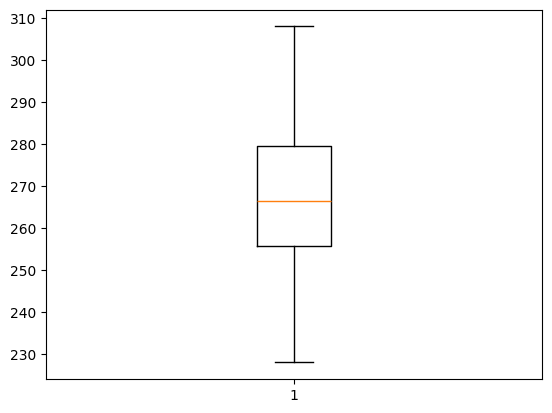

In [122]:
plt.boxplot([np.sum(mcbe.relu(x=X_test[i],W=weights,b=max_bias) > 0) for i in range(100)])

In [109]:
weights.shape

(512, 256)